# Matrix–Vector and Matrix–Matrix Multiplication
**Topic:** Applications in Data Science and Machine Learning using MNIST

In this notebook, we will:
- Use tiny \(4 x 4\) patches from MNIST digit images
- Demonstrate **matrix–vector** and **matrix–matrix** multiplication
- Show how these operations appear in image processing and ML

We’ll keep matrices small for clarity, but the same ideas apply to large images and datasets.


## About the MNIST Dataset

We will use the **MNIST** dataset — a famous collection of handwritten digits (0–9).  
- Each image is **28 × 28 pixels**, in grayscale.  
- Pixel values range from **0 (white)** to **255 (black)**.  
- There are **70,000 images** in total (60k for training, 10k for testing).

In our examples, we won’t use the full dataset — just **one small patch** (like \(4 x 4\)) from a single image.


In [5]:
# Step 1 — Setup: imports and MNIST loader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X_all = mnist['data']
    y_all = mnist['target'].astype(int)
    print('Loaded MNIST via sklearn.fetch_openml — shape', X_all.shape)
except Exception:
    try:
        from tensorflow.keras.datasets import mnist as k_mnist
        (x_tr, y_tr), (x_te, y_te) = k_mnist.load_data()
        X_all = np.vstack([x_tr.reshape(-1, 28*28), x_te.reshape(-1, 28*28)])
        y_all = np.hstack([y_tr, y_te])
        print('Loaded MNIST via keras.datasets.mnist — shape', X_all.shape)
    except Exception:
        raise RuntimeError('Could not load MNIST. Please install scikit-learn or tensorflow.')

# Helper: display full image and zoomed patch
def show_image_and_patch(img28, patch_coords=(0,0), patch_size=4, title=None):
    r, c = patch_coords
    patch = img28[r:r+patch_size, c:c+patch_size]
    fig = plt.figure(figsize=(6,3))
    gs = gridspec.GridSpec(1,2, width_ratios=[1.2,1])

    ax0 = fig.add_subplot(gs[0])
    ax0.imshow(img28, cmap='gray', interpolation='nearest')
    ax0.set_title('28×28 MNIST image' + (f' — {title}' if title else ''))
    ax0.axis('off')

    ax1 = fig.add_subplot(gs[1])
    ax1.imshow(patch, cmap='gray', interpolation='nearest')
    ax1.set_title(f'Patch {patch_size}×{patch_size} at {patch_coords}')
    ax1.axis('off')
    plt.show()


Loaded MNIST via sklearn.fetch_openml — shape (70000, 784)


## Why see an image as a matrix?

A grayscale image is just a **grid of numbers** — each number shows how dark a pixel is.  
For example, a 28 × 28 MNIST digit is a **28 × 28 matrix** \( X \), where:

- $\( X_{ij} \$) = pixel value at row \( i \), column \( j \)
- Values are between **0 (white)** and **255 (black)**

Once we think of images as matrices, **matrix operations** become powerful tools:
- **Matrix–vector multiplication** → Flatten an image into a vector to feed into a neural network layer.
- **Matrix–matrix multiplication** → Transform rows or columns (e.g., scaling brightness, blurring, edge detection).
- **Linear transformations** → Apply filters, rotate, mix pixel values — all common in image processing and ML.

We will start from a **small 4 × 4 patch** of an MNIST digit to keep the math clear,  
and apply matrix operations step-by-step to see how the numbers (and the image) change.


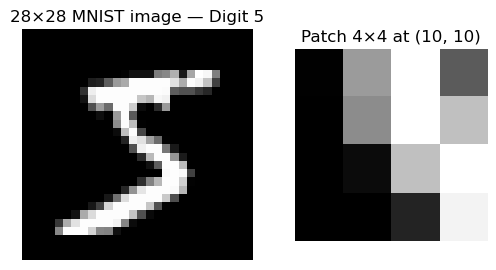

4×4 patch matrix:
[[  1 154 253  90]
 [  0 139 253 190]
 [  0  11 190 253]
 [  0   0  35 241]]


In [12]:
# Step 2 — Pick one image and extract a 4×4 patch

# Pick the first image (digit '5' in MNIST, usually)
img = X_all[0].reshape(28, 28)  # reshape from 784 → 28×28

# Coordinates of the top-left corner of the patch
patch_coords = (10, 10)  # somewhere in the middle of the image
patch_size = 4

# Extract the patch as a matrix
r, c = patch_coords
patch_matrix = img[r:r+patch_size, c:c+patch_size]

# Show the image + patch
show_image_and_patch(img, patch_coords=patch_coords, patch_size=patch_size, title=f"Digit {y_all[0]}")

# Print the matrix values
print("4×4 patch matrix:")
print(patch_matrix)


### Vectorizing an Image Patch

- Each image patch (here 4×4) is a **matrix of pixel intensities**.  
- To perform linear algebra operations like **dot products, filtering, or transformations**, we often **vectorize** the patch:
  - Flatten the 2D matrix into a 1D column vector.
  - Shape goes from `(4,4)` → `(16,1)`.
- This allows us to represent the patch as a **single vector**, making it compatible with:
  - Linear transformations (`A @ x`)  
  - Feature extraction for ML models  
  - Convolution-like operations in a simplified, linear algebra context


In [61]:
# Flatten the 4x4 patch into a vector
patch_vector = patch_matrix.reshape(-1, 1)  # shape (16,1)

print("Vectorized 4×4 patch (16x1 column vector):")
print(patch_vector)
print("Shape:", patch_vector.shape)


Vectorized 4×4 patch (16x1 column vector):
[[  1]
 [154]
 [253]
 [ 90]
 [  0]
 [139]
 [253]
 [190]
 [  0]
 [ 11]
 [190]
 [253]
 [  0]
 [  0]
 [ 35]
 [241]]
Shape: (16, 1)


## Matrix–Vector Multiplication in Image Processing

If we take our 4 × 4 patch \( P \), we can treat each **row** of pixels as a vector.  

Matrix–vector multiplication means:

$$
\mathbf{y} = P \cdot \mathbf{v}
$$

Where:
- \( P \) is our **4 × 4 patch matrix**.
- $\ \mathbf{v} \ $ is a **4 × 1 column vector**.

**What does this do?**
- Each entry of \( \mathbf{y} \) is a **weighted sum** of the row’s pixel values.
- By choosing different \( \mathbf{v} \), we can **emphasize** or **reduce** certain columns.
- This is like applying a **filter** in one direction (horizontal influence).

**In real-world ML:**
- Neural networks often flatten an image into a long vector and multiply by a weight vector or matrix.
- Early layers can be thought of as many such weighted sums, detecting simple patterns like edges or blobs.


Weight vector v:
[[ 1. ]
 [-1. ]
 [ 0.5]
 [ 0. ]]

Result y = P · v:
[[-26.5]
 [-12.5]
 [ 84. ]
 [ 17.5]]


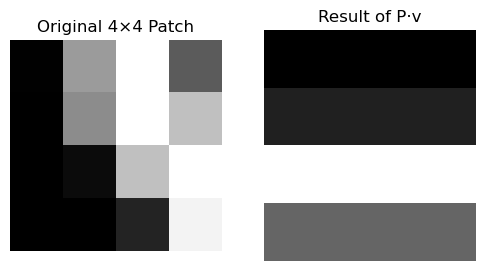

In [22]:
# Step 3 — Matrix–Vector multiplication on the patch

# Define a weight vector (4x1) — try different values for fun
v = np.array([1, -1, 0.5, 0]).reshape(4, 1)

# Perform matrix–vector multiplication
y = patch_matrix @ v  # same as np.dot(patch_matrix, v)

# Show results
print("Weight vector v:")
print(v)

print("\nResult y = P · v:")
print(y)

# Optional: visualize original patch vs. transformed column
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(patch_matrix, cmap='gray', interpolation='nearest')
plt.title("Original 4×4 Patch")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(y, cmap='gray', interpolation='nearest', aspect='auto')
plt.title("Result of P·v")
plt.axis('off')

plt.show()


## Seeing the Effect of Different Weight Vectors

In matrix–vector multiplication \( \mathbf{y} = P \cdot \mathbf{v} \):

- \( P \) is our **4 × 4 patch**.
- $\\mathbf{v} \$ is a **4 × 1 weight vector**.

Each value in $\ \mathbf{v} \$ tells us **how much to emphasize each column** of pixels.

When we try different $\ \mathbf{v} \$ values:

1. **[1, 0, 0, 0]** → Picks only the **first column** of the patch.  
2. **[1, 1, 1, 1]** → Adds all columns equally (averaging horizontally).  
3. **[1, -1, 0, 0]** → Finds the **difference** between the first two columns (detects vertical edges).  
4. **[0.5, 0.5, -0.5, -0.5]** → Averages the first two columns, subtracts the last two (more complex edge/contrast detection).

**Why this matters for Data Science & ML:**
- Neural networks use this idea in **filters** (also called kernels) to detect patterns like edges, corners, or textures.
- Even simple linear algebra operations can reveal structure in data — the building blocks of image recognition.

Think of $\ \mathbf{v} \$ as a set of **sliders** that tune which parts of an image’s data are highlighted or suppressed.


[[  1 154 253  90]
 [  0 139 253 190]
 [  0  11 190 253]
 [  0   0  35 241]]


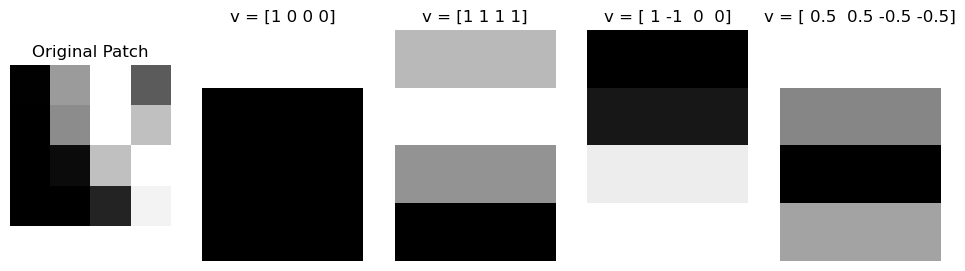

In [50]:
# Step 3b — Multiple weight vectors demonstration

# Try a few different weight vectors
weight_vectors = [
    np.array([1, 0, 0, 0]).reshape(4, 1),      # Pick only first column
    np.array([1, 1, 1, 1]).reshape(4, 1),      # Sum all columns equally
    np.array([1, -1, 0, 0]).reshape(4, 1),     # Difference between col1 and col2
    np.array([0.5, 0.5, -0.5, -0.5]).reshape(4, 1)  # Average first two, subtract last two
]

fig, axes = plt.subplots(1, len(weight_vectors)+1, figsize=(12,3))

# Show original patch
axes[0].imshow(patch_matrix, cmap='gray', interpolation='nearest')
axes[0].set_title("Original Patch")
axes[0].axis('off')
print(patch_matrix)
# Apply each weight vector and show result
for i, v in enumerate(weight_vectors, start=1):
    y = patch_matrix @ v            # 4x1 result
    y_display = np.tile(y, (1, 4))  # Repeat the column 4 times for better visualization
    axes[i].imshow(y_display, cmap='gray', interpolation='nearest', aspect='auto')
    axes[i].set_title(f"v = {v.flatten()}")
    axes[i].axis('off')

plt.show()
